# Datenaufbereitung durch ermittlen der Koordinaten

### Hinzufügen von Koordinaten

Adressen mittels der Google-Geocode-API in Koordinaten umwandeln um nummerische Daten für weiteren Berechnung zu erhalten

In [ ]:
import json
import requests
import time
import os
from tqdm import tqdm

# Lade die Daten
def load_data(file_name):
    with open(file_name, 'r', encoding='utf-8') as file:
        loaded_data = json.load(file)
    return loaded_data

# Sonderzeichen behandeln
def handle_special_characters(value):
    if isinstance(value, str):  # Überprüfen, ob der Wert ein String ist
        # Umlaute umwandeln
        value = value.replace("ß", "ss")
        value = value.replace("ä", "ae")
        value = value.replace("Ä", "Ae")
        value = value.replace("Ü", "Ue")
        value = value.replace("ü", "ue")
        value = value.replace("ö", "oe")
    return value

# Sonderzeichen in den geladenen Daten ersetzen
def handle_special_chars_in_data(loaded_data):
    decoded_data = []
    for dictionary in loaded_data:
        new_dict = {}
        for key, value in dictionary.items():
            new_dict[key] = handle_special_characters(value)
        decoded_data.append(new_dict)
    return decoded_data

# Funktion zum Formatieren der Adresse
def format_address(item):
    bundesland = item['bundesland']
    stadtteil = item['stadtteil']
    stadt = item['stadt']
    strasse = item.get('strasse', '')  # Falls 'strasse' nicht vorhanden ist, setze einen leeren String
    plz = item['plz']
    return f"{strasse}, {plz} {stadtteil}, {stadt}, {bundesland}"

# Gehe durch die ursprünglichen Daten und formatiere die Adressen
def format_addresses(decoded_data):
    new_data = []
    for item in tqdm(decoded_data, desc="Adressformatierung", total=len(decoded_data)):
        address = format_address(item)
        item['address'] = address
        new_data.append(item)
    return new_data

def geocode_google(address, api_key):
    # Geocodierung einer Adresse
    url = f"https://maps.googleapis.com/maps/api/geocode/json?address={address}&key={api_key}"
    response = requests.get(url)
    data = response.json()
    if data['results']:
        location = data['results'][0]['geometry']['location']
        return location['lat'], location['lng']
    else:
        return None, None

# Speichern der endgültigen Daten in eine JSON-Datei
def save_to_json(data, output_filename):
    with open(output_filename, 'w', encoding='utf-8') as file:
        json.dump(data, file, ensure_ascii=False, indent=2)

def main():
    api_key = "Private_Google_key!!!"
    input_filename = "trainingData.json"
    output_filename = "trainingData_located.json"
    
    # Lade die Daten ein
    loaded_data = load_data(input_filename)

    # Handle special characters
    decoded_data = handle_special_chars_in_data(loaded_data)
    
    # Format addresses
    new_data = format_addresses(decoded_data)

    for item in new_data:
        address = item['address']

        # Geocodierung der Adresse
        latitude, longitude = geocode_google(address, api_key)

        # Fügt die geocodierten Daten zu den vorhandenen Daten hinzu
        if latitude and longitude:
            item['Latitude'] = latitude
            item['Longitude'] = longitude
        
    # Speichern der endgültigen Daten in eine JSON-Datei
    save_to_json(new_data, output_filename)

if __name__ == "__main__":
    main()

### Anzeigen der Datenpunkte

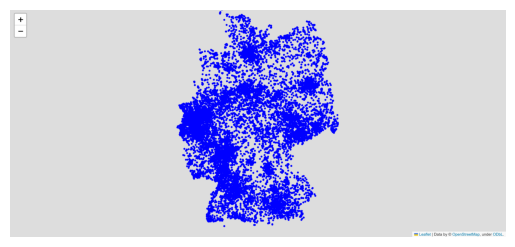

In [8]:
import folium
import json
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pathlib import Path
from selenium import webdriver

# Pfad zu den JSON-Dateien
current_directory = Path().resolve()
file_pattern = current_directory / "Historical_Data" / "trainingData_located2010.json"

# Lese die JSON-Datei ein
with open(file_pattern, 'r') as file:
    data = json.load(file)

# Erstelle eine Karte von Deutschland
map_germany = folium.Map(location=[51.1657, 10.4515], zoom_start=6)

# Iteriere über die Datenpunkte und füge Marker zur Karte hinzu
for item in data:
    latitude = float(item['Latitude'])
    longitude = float(item['Longitude'])
    folium.CircleMarker(location=[latitude, longitude], radius=0.5, color='blue', fill=True, fill_color='blue').add_to(map_germany)

# Speichere die Karte als HTML
map_file_path = "temp_map.html"
map_germany.save(map_file_path)

# Benutzen Sie Selenium und den Firefox-Webdriver, um einen Screenshot zu machen
browser = webdriver.Firefox()
browser.get("file://" + str(current_directory / map_file_path))
screenshot_path = "map_screenshot.png"
browser.save_screenshot(screenshot_path)
browser.quit()

# Benutzen Sie matplotlib, um das Bild anzuzeigen
img = mpimg.imread(screenshot_path)
plt.imshow(img)
plt.axis('off')
plt.show()